## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [2]:
ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [3]:
slice_name="fabnet"

## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [4]:
slice_manager = SliceManager()


### Orchestrator API example to query for available resources

In [5]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: RENC [Site] : { cpu: 6/6 , core: 192/192 , ram: 1,536/1,536 G, disk: 60,600/60,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
		RENC_UKY: TrunkPort { bw: 10/10 Gbps}
		RENC_LBNL: TrunkPort { bw: 10/10 Gbps}
LBNL [Site] : { cpu: 6/6 , core: 192/192 , ram: 1,536/1,536 G, disk: 60,600/60,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { un

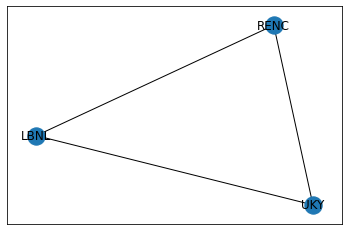

In [6]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

## Site1
- Grab the subnet from NetworkService Sliver for Site 1
- Use the subnet to assign IPs to the VMs
    - IPV4 Example Subnet Returned: (10.130.1.0/24). Do not use 1st IP Address i.e. 10.130.1.1/24.
    ```
    ip addr add 10.130.1.2/24 dev eth1
    ```
    - IPV6 Example Subnet Returned: (2602:fcfb:4:1::0/64)
    ```
    ip -6 address add 2602:fcfb:4:1::2/64 dev eth1. Do not use 1st IP Address i.e. 2602:fcfb:4:1::1/64.
    ```
- Add route to the Site 2 Subnet
  - IPv4
  ```
  ip route add 10.129.1.0/24 via 10.130.1.1
  ```
  - IPv6
  ```
  ip -6 route add 2602:fcfb:8:1::/64 via 2602:fcfb:4:1::1
  ```
## Site2
- Grab the subnet from NetworkService Sliver for Site 2
- Use the subnet to assign IPs to the VMs
    - IPV4 Example Subnet Returned: (10.129.1.0/24). Do not use 1st IP Address i.e. 10.129.1.1/24.
    ```
    ip addr add 10.129.1.2/24 dev eth1
    ```
    - IPV6 Example Subnet Returned: (2602:fcfb:8:1::0/64). Do not use 1st IP Address i.e. 2602:fcfb:8:1::1/64.
    ```
    ip -6 address add 2602:fcfb:8:1::2/64 dev eth1
    ```
- Add route to the Site 2 Subnet
  - IPv4
  ```
  ip route add 10.130.1.0/24 via 10.129.1.1
  ```
  - IPv6
  ```
  ip -6 route add 2602:fcfb:4:1::/64 via 2602:fcfb:8:1::1
  ```
  

In [7]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Set capacities
cap = Capacities(core=2, ram=6, disk=10)


site1 = "UKY"
site2 = "LBNL"
num_nodes = 2
name="node"
i=0
ifcs = []
for x in range(num_nodes):
    # Add node
    nm = f"{name}-{i}"
    
    n = t.add_node(name=f"{name}-{i}", site=site1)

    # Set properties
    n.set_properties(capacities=cap, image_type='qcow2', image_ref='default_rocky_8')
    if i == 0:
        n.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name=f"{name}-{i}-nic1")
    elif i == 1:
        n.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name=f"{name}-{i}-nic1")
    else:
        n.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=f"{name}-{i}-nic1")
    
    ifcs.append(n.interface_list[0])
        
    i += 1

t.add_network_service(name=f"fabnet-{site1}", nstype=ServiceType.FABNetv4, interfaces=ifcs)

ifcs.clear()

for x in range(num_nodes):
    # Add node
    nm = f"{name}-{i}"
    
    n = t.add_node(name=f"{name}-{i}", site=site2)

    # Set properties
    n.set_properties(capacities=cap, image_type='qcow2', image_ref='default_rocky_8')
    if i == 0:
        n.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name=f"{name}-{i}-nic1")
    elif i == 1:
        n.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name=f"{name}-{i}-nic1")
    else:
        n.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=f"{name}-{i}-nic1")
    
    ifcs.append(n.interface_list[0])
        
    i += 1

t.add_network_service(name=f"fabnet-{site2}", nstype=ServiceType.FABNetv4, interfaces=ifcs)


# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=ssh_key_pub)


print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "be4862d3-07a0-4eb9-bc3a-8511547501f1",
    "lease_end": "2022-02-25 18:41:49",
    "lease_start": "2022-02-24 18:41:49",
    "pending_state": "None_",
    "reservation_id": "5eb500c5-d3f3-4210-a54a-fc6ab8edf596",
    "reservation_state": "Unknown",
    "slice_id": "b39e8a42-536a-40f4-952e-3480047c2a4d"
}, {
    "graph_node_id": "67fb736b-7f8a-4507-a572-0e40d96fc87c",
    "lease_end": "2022-02-25 18:41:49",
    "lease_start": "2022-02-24 18:41:49",
    "pending_state": "None_",
    "reservation_id": "25d52b58-48a5-4167-aef3-31d420530abe",
    "reservation_state": "Unknown",
    "slice_id": "b39e8a42-536a-40f4-952e-3480047c2a4d"
}, {
    "graph_node_id": "b7048212-b521-41d9-ace0-1e31fe388180",
    "lease_end": "2022-02-25 18:41:49",
    "lease_start": "2022-02-24 18:41:49",
    "pending_state": "None_",
    "reservation_id": "fafc1c8e-924f-4676-b233-f5c44621495e",
    "reservation_state": "Unknown",
    "slice_id": "

## Query Slices

In [12]:
status, slices = slice_manager.slices(excludes=[SliceState.Closing, SliceState.Dead])

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
    if len(slices) > 0:
        slice_object=list(filter(lambda s: s.slice_name == slice_name, slices))[0]
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "9524d015-62cc-45f3-b7a3-9c886f7d0ce9",
    "lease_end": "2022-02-25 18:41:49",
    "slice_id": "b39e8a42-536a-40f4-952e-3480047c2a4d",
    "slice_name": "fabnet",
    "slice_state": "StableOK"
}]


## Query Slivers

In [13]:
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    for s in slivers:
        print("=====================")
        print("ReservationId {}".format(s.reservation_id))
        print("State         {}".format(s.reservation_state))
        print("Pending       {}".format(s.pending_state))
        print("Join State    {}".format(s.join_state))
        print("Sliver Type   {}".format(s.sliver_type))
        # print("Sliver        {}".format(s.sliver))
        print("Site        {}".format(s.sliver.site))
        if s.sliver_type == "NodeSliver":
            print("Sliver        {}".format(s.sliver.management_ip))
        else:
            print("Sliver        {}".format(s.sliver.gateway.subnet))
        '''
        if s.sliver_type == "NodeSliver":
            for d in s.sliver.attached_components_info.devices.values():
                print("-------------------------")
                print("COMPONENT        {}".format(d))
                print("-------------------------")
        else:
            for d in s.sliver.interface_info.interfaces.values():
                print("-------------------------")
                print("INTERFACE        {}".format(d))
                print("-------------------------")
                
        print("Notices       {}".format(s.notices))
        '''
        print("=====================")
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
ReservationId d221b5c0-bbfb-4aba-86ab-dd4110b19689
State         Active
Pending       None_
Join State    NoJoin
Sliver Type   NodeSliver
Site        LBNL
Sliver        198.129.61.39
ReservationId 25d52b58-48a5-4167-aef3-31d420530abe
State         Active
Pending       None_
Join State    NoJoin
Sliver Type   NodeSliver
Site        UKY
Sliver        128.163.179.30
ReservationId 1b3d6ef1-9201-4551-b6aa-cd14822fc4b8
State         Active
Pending       None_
Join State    NoJoin
Sliver Type   NetworkServiceSliver
Site        LBNL
Sliver        10.129.1.0/24
ReservationId fafc1c8e-924f-4676-b233-f5c44621495e
State         Active
Pending       None_
Join State    NoJoin
Sliver Type   NodeSliver
Site        LBNL
Sliver        198.129.61.43
ReservationId 565646fd-2f0f-478e-838d-e87fa299d6de
State         Active
Pending       None_
Join State    NoJoin
Sliver Type   NetworkServiceSliver
Site        UKY
Sliver        10.128.129.0/24
ReservationId 5eb500c5-d3f3-4210-a54a-

## Delete Slice

In [14]:
status, result = slice_manager.delete(slice_object=slice_object)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
